In [16]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchcam.methods import SmoothGradCAMpp, GradCAM
import torchvision.models as models
import numpy as np
from torchcam.utils import overlay_mask
import torch.nn
import torch.nn.functional as F
from torchvision import transforms
import requests, io
from torch.autograd import Variable
%matplotlib inline

In [17]:
model = models.resnet18(pretrained=True).eval()

In [18]:
# 图像预处理
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
preprocess = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean, std)
                                ])

In [19]:
# 可视化热力图的类别ID，如果为 None，则为置信度最高的预测类别ID
# show_class_id = 281
show_class_id = None

In [20]:
# 加载示例图像并进行预处理
image_path = 'cloud.png'
image = Image.open(image_path).convert('RGB')
input_image = preprocess(image)
input_image = input_image.unsqueeze(0)  # 添加批次维度

img_variable = Variable(input_image, requires_grad=True) #convert tensor into a variable

In [21]:
# 初始化SmoothGradCAM++
cam = GradCAM(model)

In [22]:
pred_logits = model(input_image)
pred_top1 = torch.topk(pred_logits, 1)
pred_id = pred_top1[1].detach().cpu().numpy().squeeze().item()
pred_id

958

In [23]:
output = model.forward(img_variable)
label_idx = int(torch.max(output.data, 1)[1][0])   #get an index(class number) of a largest element
labels_link = "https://savan77.github.io/blog/labels.json"    
labels_json = requests.get(labels_link).json()
labels = {int(idx):label for idx, label in labels_json.items()}
x_pred = labels[label_idx]
print(x_pred)

hay


In [24]:
#get probability dist over classes
output_probs = F.softmax(output, dim=1)
x_pred_prob =  float((torch.max(output_probs.data, 1)[0][0]) * 100)
print(x_pred_prob)

4.228526592254639


In [25]:
# 可视化热力图的类别ID，如果不指定，则为置信度最高的预测类别ID
if show_class_id:
    show_id = show_class_id
else:
    show_id = pred_id
    show_class_id = pred_id

In [26]:
# 生成可解释性分析热力图
activation_map = cam(show_id, pred_logits)
activation_map = activation_map[0][0].detach().cpu().numpy()
result = overlay_mask(image, Image.fromarray(activation_map), alpha=0.01)

In [27]:
activation_map

array([[0.        , 0.16431706, 0.26300594, 0.26339588, 0.14497392,
        0.14110899, 0.05469037],
       [0.23061156, 0.3759628 , 0.4083662 , 0.44686976, 0.34079438,
        0.34586576, 0.20172499],
       [0.26898077, 0.37039757, 0.33981252, 0.38146895, 0.26009172,
        0.3711504 , 0.21580784],
       [0.48187652, 0.6941531 , 0.6423765 , 0.70585793, 0.4568798 ,
        0.5901724 , 0.3415569 ],
       [0.4424316 , 0.63010466, 0.59360427, 0.68391865, 0.41176042,
        0.54911256, 0.3239537 ],
       [0.49620205, 0.7918912 , 0.9135744 , 1.        , 0.791498  ,
        0.7016404 , 0.30206707],
       [0.2662071 , 0.45919234, 0.56232095, 0.65434265, 0.64293325,
        0.6093856 , 0.27688548]], dtype=float32)

In [28]:
import math

# 计算热力图标准差
def StandardDeviation(map):  # map为热力图
    n = len(map) ** 2
    h_average = sum(sum(map)) / n
    total = 0
    for hi in map:
        for hj in hi:
            total += (hj - h_average) ** 2  
    total /= n
    return math.sqrt(total)

# 计算热力图熵
def entropy(map):
    n = len(map) ** 2
    dic = {}
    for pi in map:
        for pj in pi:
            pj = round(pj,3)
            if pj not in dic.keys():
                dic[pj] = 1
            else:
                dic[pj] += 1
    total = 0
    tmp = map.copy()
    for i in range(len(tmp)):
        for j in range(len(tmp[0])):
            tmp[i][j] = dic[round(tmp[i][j],3)] / n
            total += tmp[i][j] * math.log(tmp[i][j])
    return -total

# 设置阈值，计算热力图高于阈值的百分比
def percentile(map, threshold):
    n = len(map) ** 2
    total = 0
    for pi in map:
        for pj in pi:
            if pj < threshold:
                total += 1
    return total / n * 100

In [29]:
StandardDeviation(activation_map)

0.21834609643716088

In [30]:
entropy(activation_map)

3.9940866023759156

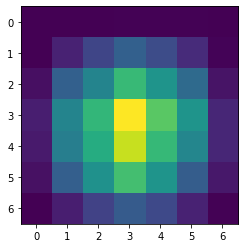

In [16]:
np.argmax(activation_map)
plt.imshow(activation_map)
plt.show()

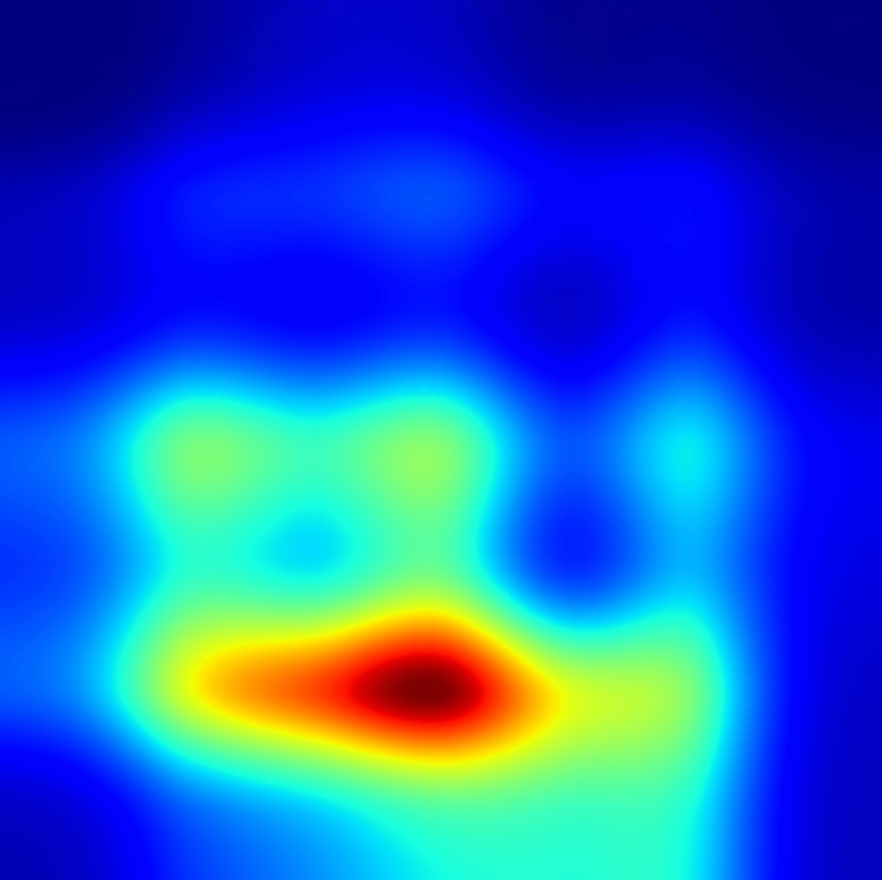

In [17]:
result

In [17]:
activation_map = torch.from_numpy(activation_map)
heat_topk = torch.topk(activation_map.flatten(), 49).indices  # topk热力值的索引位置（将整个32x32拉通了）
heat_topk = heat_topk.tolist()

In [18]:
heat_coordinate = {}
index_list = [[0,31], [32,63], [64,95], [96,127], [128,160], [161,192], [193,224]]
for i in heat_topk:
    if i not in heat_coordinate.keys():
        y = index_list[i//7]
        x = index_list[i%7]
        heat_coordinate[i] = [y, x]

In [19]:
heat_coordinate

{17: [[64, 95], [96, 127]],
 24: [[96, 127], [96, 127]],
 10: [[32, 63], [96, 127]],
 31: [[128, 160], [96, 127]],
 25: [[96, 127], [128, 160]],
 16: [[64, 95], [64, 95]],
 18: [[64, 95], [128, 160]],
 38: [[161, 192], [96, 127]],
 23: [[96, 127], [64, 95]],
 32: [[128, 160], [128, 160]],
 9: [[32, 63], [64, 95]],
 11: [[32, 63], [128, 160]],
 26: [[96, 127], [161, 192]],
 45: [[193, 224], [96, 127]],
 39: [[161, 192], [128, 160]],
 30: [[128, 160], [64, 95]],
 46: [[193, 224], [128, 160]],
 15: [[64, 95], [32, 63]],
 33: [[128, 160], [161, 192]],
 3: [[0, 31], [96, 127]],
 19: [[64, 95], [161, 192]],
 22: [[96, 127], [32, 63]],
 8: [[32, 63], [32, 63]],
 2: [[0, 31], [64, 95]],
 40: [[161, 192], [161, 192]],
 37: [[161, 192], [64, 95]],
 12: [[32, 63], [161, 192]],
 29: [[128, 160], [32, 63]],
 44: [[193, 224], [64, 95]],
 4: [[0, 31], [128, 160]],
 47: [[193, 224], [161, 192]],
 1: [[0, 31], [32, 63]],
 36: [[161, 192], [32, 63]],
 43: [[193, 224], [32, 63]],
 5: [[0, 31], [161, 192]

In [20]:
# 开始fgsm
y_true = 281   #tiger cat  ##change this if you change input image
target = Variable(torch.LongTensor([y_true]), requires_grad=False)

In [21]:
#perform a backward pass in order to get gradients
loss = torch.nn.CrossEntropyLoss()
loss_cal = loss(output, target)
loss_cal.backward(retain_graph=True)    #this will calculate gradient of each variable (with requires_grad=True) and can be accessed by "var.grad.data"

In [22]:
eps = 0.02
x_grad = torch.sign(img_variable.grad.data)                #calculate the sign of gradient of the loss func (with respect to input X) (adv)

In [23]:
probs = []
pred_labels = []
specified_class_index = 281

for i in heat_coordinate.values():
    # 处理，只保留选中方框内的梯度值
    x_tmp = torch.zeros(1, 3, 224, 224)
    x_grad = torch.sign(img_variable.grad.data)
    x_tmp[0][:,i[0][0]:i[0][1],i[1][0]:i[1][1]] = x_grad[0][:,i[0][0]:i[0][1],i[1][0]:i[1][1]]
    x_grad = x_tmp
    x_adversarial = img_variable.data + eps * x_grad          #find adv example using formula shown above
    output_adv = model.forward(Variable(x_adversarial))   #perform a forward pass on adv example
    x_adv_pred = labels[int(torch.max(output_adv.data, 1)[1][0])]    #classify the adv example
    pred_labels.append(x_adv_pred)
    # 将模型输出结果转换为概率分布
    probabilities = torch.softmax(output_adv, dim=1)[0].tolist()
    specified_class_probability = probabilities[specified_class_index]
    
    probs.append(specified_class_probability)

In [24]:
activation_map.sort()

torch.return_types.sort(
values=tensor([[0.0000e+00, 6.7016e-04, 1.1731e-01, 1.9695e-01, 2.7458e-01, 3.5246e-01,
         4.2276e-01],
        [1.5351e-02, 3.0515e-02, 3.0064e-01, 3.5695e-01, 5.0919e-01, 5.5968e-01,
         7.8929e-01],
        [1.9046e-02, 4.8476e-02, 4.0041e-01, 4.3574e-01, 6.0160e-01, 6.5616e-01,
         1.0000e+00],
        [6.8009e-03, 8.4218e-02, 3.6987e-01, 5.0183e-01, 5.7206e-01, 6.7058e-01,
         9.5617e-01],
        [1.4847e-02, 1.0119e-01, 2.9178e-01, 4.2822e-01, 4.4370e-01, 5.6563e-01,
         7.4928e-01],
        [1.1144e-02, 8.6058e-02, 1.7967e-01, 3.1203e-01, 3.4003e-01, 4.8688e-01,
         5.7551e-01],
        [4.8512e-03, 6.8195e-02, 1.2866e-01, 2.5520e-01, 2.8496e-01, 4.3903e-01,
         4.9106e-01]]),
indices=tensor([[0, 6, 5, 1, 4, 2, 3],
        [0, 6, 5, 1, 4, 2, 3],
        [0, 6, 5, 1, 4, 2, 3],
        [0, 6, 1, 5, 2, 4, 3],
        [0, 6, 1, 5, 2, 4, 3],
        [0, 6, 1, 2, 5, 4, 3],
        [0, 6, 1, 5, 2, 4, 3]]))

In [32]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

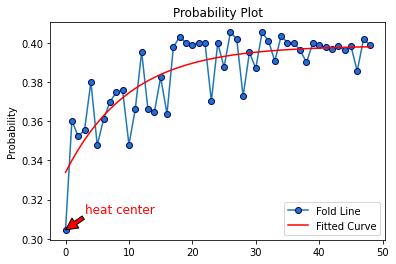

In [56]:
# 创建横坐标
x = np.arange(0, 49)
y = probs
# 使用curve_fit函数来拟合非线性数据
popt, pcov = curve_fit(func, x, y)

# 绘制折线图
plt.plot(x, y, marker='o', mec='darkblue', label="Fold Line")

# 画出原始数据散点图和拟合曲线
# plt.scatter(x, y, label="Data")
plt.plot(x, func(x, *popt), color='red', label="Fitted Curve")

# 设置标题和坐标轴标签
plt.title('Probability Plot')
# plt.text(0, y[0], '  heat center')
#添加带有箭头的文本注释
plt.annotate('heat center', xy=(0, y[0]), xytext=(3.1, 0.313), fontsize=12, color='red', arrowprops=dict(facecolor='red'))
plt.ylabel('Probability')
# 添加图例
plt.legend()
# 显示图形
plt.show()

In [44]:
eps = 0.2
x_grad = torch.sign(img_variable.grad.data)                #calculate the sign of gradient of the loss func (with respect to input X) (adv)
# 处理，只保留选中方框内的梯度值
x_tmp = torch.zeros(1, 3, 224, 224)
# 一个是从上往下数，一个是从左往右数
# x_tmp[0][:,32:127,96:127] = x_grad[0][:,32:127,96:127]  # 32一步，0-31,32-63,64-95,96-127,128-160,161-192,193-224
# x_tmp[0][:,64:95,128:160] = x_grad[0][:,64:95,128:160]
# x_tmp[0][:,32:95,64:95] = x_grad[0][:,32:95,64:95]

# x_tmp[0][:,:,193:224] = x_grad[0][:,:,193:224]
# x_tmp[0][:,:,0:31] = x_grad[0][:,:,0:31]
# x_tmp[0][:,96:224,32:63] = x_grad[0][:,96:224,32:63]
# x_tmp[0][:,0:31,161:192] = x_grad[0][:,0:31,161:192]
# x_tmp[0][:,128:224,64:95] = x_grad[0][:,128:224,64:95]

x_tmp[0][:,64:95,96:127] = x_grad[0][:,64:95,96:127]
x_grad = x_tmp

x_adversarial = img_variable.data + eps * x_grad          #find adv example using formula shown above
output_adv = model.forward(Variable(x_adversarial))   #perform a forward pass on adv example
x_adv_pred = labels[int(torch.max(output_adv.data, 1)[1][0])]    #classify the adv example
op_adv_probs = F.softmax(output_adv, dim=1)                 #get probability distribution over classes
adv_pred_prob =  float((torch.max(op_adv_probs.data, 1)[0][0]) * 100)      #find probability (confidence) of a predicted class

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [52]:
# 在最大值位置添加扰动
perturbed_image[0, :, max_coords[1], max_coords[2]] += perturbation

In [53]:
# 将像素值限制在 [0, 1] 范围内
perturbed_image = torch.clamp(perturbed_image, 0, 1)

Text(0.5, 1.0, 'Perturbed Image')

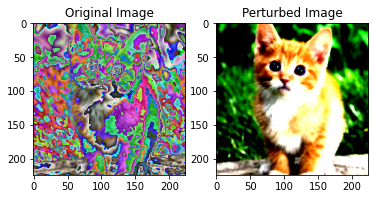

In [54]:
# 可视化原图和带有扰动的图像
plt.subplot(1, 2, 1)
plt.imshow(transforms.ToPILImage()(input_image.squeeze()))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(transforms.ToPILImage()(perturbed_image.squeeze()))
plt.title('Perturbed Image')

In [86]:
# 加载示例图像并进行预处理
image_path = '1.png'
image = Image.open(image_path).convert('RGB')
shape = (224, 224)
image = image.resize(shape)
pixels = image.load()

In [87]:
# 这张图被分为7*7，[2,3]最大
side_len = image.width // 7
width_start = side_len * 3  # 改变范围的宽从此处开始
height_start = side_len * 2

In [74]:
# 下面是整张图扰动的情况
count = 0
while predict(image) == 281:
    count += 1
    i = random.randint(0, 223)   
    j = random.randint(0, 223)
    pixels[i, j] = (0, 0, 0)

In [102]:
# 遍历每个像素点并修改（修改成一整个黑块），i是横着，j是竖着，从左上角开始数
# for i in range(width_start, width_start + side_len + 1):
#     for j in range(height_start, height_start + side_len + 1):
for i in range(0, side_len + 1):
    for j in range(0, 224):
        # 获取像素点RGB值
        r, g, b = pixels[i, j]
        # 修改像素点值
        pixels[i, j] = (0, 0, 0)

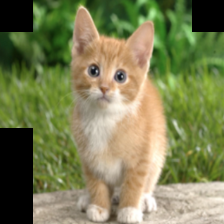

In [101]:
image

In [61]:
# 重新过模型
def predict(image):
    perturbed_image = preprocess(image)
    perturbed_image = perturbed_image.unsqueeze(0).to(device)  # 添加批次维度
    pred_logits = model(perturbed_image)
    pred_top1 = torch.topk(pred_logits, 1)
    pred_id = pred_top1[1].detach().cpu().numpy().squeeze().item()
    return pred_id

In [ ]:
# 我觉得可以试一下按照贡献度的大小来rand，就是贡献度大的rand多一些，贡献度小的rand少一些